In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

#memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('seaborn-white')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

In [91]:
def save_df(df, df_name='default', rel_path='/data/final/', verbose=True):
    """
    simple function for saving result table. uses the date and supplied df name and saves to the savepath specified above.
    """
    global folder
    
    save_path= str(repository_path)+rel_path
    
    address=save_path+'{}_{}/'.format(date,folder)
    if not os.path.exists(address):
        if verbose==True:
            print(address)
        os.makedirs(address)
    else:
        if verbose==True:
            print(address)
        
    if address.endswith('/')==False:
        address= address+'/'
        
    if df_name == 'default':
        df_name =[x for x in globals() if globals()[x] is df][0]
        
    pd.DataFrame(df).to_csv(Path(address+'{}_{}.csv'.format(date, df_name)))


time: 2.12 ms


## importing datasets

In [3]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df, categorical, save_boolean
#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 1.01 s


In [4]:
folder

'72_hr_window'

time: 3.18 ms


In [5]:
# ###########
# save_boolean=False
# ############

time: 228 µs


In [6]:

def data_import(allFiles):
    """
    function to import x_train, x_test, y_train, and y_test using glob of the data/final folder.
    """
    for name in allFiles:
        if 'test' in name:
            if 'x_' in name:
                x_test = pd.read_csv(name,  index_col=0)
            elif '_y_' in name:
                 y_test = pd.read_csv(name,  index_col=0)
            else:
                icu_test=pd.read_csv(name,  index_col=0)
        elif 'train' in name:
            if 'x_' in name:
                x_train = pd.read_csv(name,  index_col=0)
            elif '_y_' in name:
                 y_train = pd.read_csv(name,  index_col=0)
            else:
                icu_train=pd.read_csv(name,  index_col=0)
            
    return(x_train, x_test, y_train, y_test, icu_train, icu_test)

time: 1.47 ms


In [7]:
#importing x and y train and test, as well as icustay id and holdout longneg set

allFiles = glob.glob(str(repository_path)+ '/data/final/{}_{}/'.format(date,folder) + "*.csv")

x_train, x_test, y_train, y_test, icu_train, icu_test= data_import(allFiles)

x_longneg= pd.read_csv(str(repository_path)+ '/data/final/{}_{}/{}_x_longneg_final.csv'.format(date,'24_hr_window',date), index_col=0)
y_longneg= pd.read_csv(str(repository_path)+ '/data/final/{}_{}/{}_y_longneg_final.csv'.format(date,'24_hr_window',date), index_col=0)

time: 209 ms


### formatting x and y for modleing

In [8]:
x=np.array(x_train.copy())
y=y_train.copy() #copy of y_train
y=y.astype('int')
y=np.array(y).ravel()
#time_interval=4
z_subject_id= pd.merge(pd.DataFrame(icu_train), final_pt_df2[['icustay_id','subject_id']], how='left')['subject_id'] #7205


time: 29.5 ms


# Modelbuilding
## test entire trainset and predict trainset.
* step1) hypertune and evaluate models on 10fold cv.  
* step2) test entire train set and predict testset.
* step3) generate figures

In [9]:
from parameters import nfolds, scoring, n_iter, gridsearch
##defaults
# nfolds=10
# scoring='roc_auc'
# n_iter=20 #for gridsearch
# gridsearch=False #gridsearch=False means it does triaged hyperparameter combinations based on some algorithm. True= tests all 


time: 655 µs


In [10]:
def evaluate(model, x, y):
    "simple classification evaluation metrics and output used in my hypertuning functions"
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(x)
    y_hat_proba = model.predict_proba(x)[:, 1] 
    errors = abs(y_hat - y)
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    auc=roc_auc_score(y, y_hat_proba)
    loss= log_loss(y, y_hat_proba)
        
    print ('the AUC is: {:0.3f}'.format(auc))
    print ('the logloss is: {:0.3f}'.format(loss))
    print(confusion_matrix(y, y_hat))
    print(classification_report(y,y_hat, digits=3))
    
    if scoring=='neg_log_loss':
        return_value=loss
    elif scoring=='roc_auc':
        return_value=auc
    else:
        raise ValueError
    
    return (return_value)



time: 2.58 ms


In [11]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring=scoring, gridsearch=True, n_iter=20, verbose=False): 
    from sklearn.model_selection import GroupKFold

    np.random.seed(12345)
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         random_state=12345,
                                         n_jobs = -1)
        
    grid_search.fit(X, y, groups=z_subject_id)    
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    print('##### training set performance #####\n')   
    print(' best hypertuned model training set performance:')
    best_random = grid_search.best_estimator_
    best_random_auc = evaluate(best_random, x, y)
    
    print(' worst hypertuned model training set performance:')
    worst_params= grid_search.cv_results_['params'][worst_index]
    worst_random=model.set_params(**worst_params)
    worst_random.fit(x,y)
    worst_random_auc = evaluate(worst_random, x, y)      
          
    print('relative scorer change of {:0.2f}%. between worst and best hyperparams on TRAINING set (may be overfit)'.format( 100 * (best_random_auc - worst_random_auc) / worst_random_auc))
    
    return(grid_search)

time: 4.13 ms


In [12]:
def hypertuned_cv_fxn(x, y, model_in, nfolds):
    """
    the goal of this function is to take the best hypertuned model and 
    generate average and std for F-1, precision, recall, npv, and AUC across each fold.
    Ideally i could have generated this above in my hypertuning cv function,
    but it actually took less computational time to just rerun cv on the best performing evaluator and collect all of the averaged performance metrics
    """
    
    from sklearn.model_selection import GroupKFold
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    from sklearn.base import clone
    
    pos_label=1
    model= clone(model_in, safe=True)
    np.random.seed(12345)
    group_kfold = GroupKFold(n_splits=nfolds)
    group_kfold.get_n_splits(x, y, z_subject_id)

    f1_y_cv=[]
    auc_y_cv=[]
    prec_y_cv=[]
    recall_y_cv=[]
    npv_y_cv=[]
    tp_threshold_cv=[]

    for train_index, test_index in group_kfold.split(x, y, z_subject_id):
        x_train_cv, x_test_cv = x[train_index], x[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        model.fit(x_train_cv, y_train_cv)
        
        y_proba = model.predict_proba(x_test_cv)[:,1]
        y_pred = model.predict(x_test_cv)

        fpr, tpr, thresholds = metrics.roc_curve(y_test_cv, y_proba, pos_label=pos_label)    
        #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
        youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
        y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]
        tp_threshold_cv.append(youden_threshold)
        
        npv_y=confusion_matrix(y_test_cv, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
        npv_y_cv.append(npv_y)

        prec_y= precision_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        prec_y_cv.append(prec_y)

        recall_y= recall_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        recall_y_cv.append(recall_y)

        f1_y= f1_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        f1_y_cv.append(f1_y)

        ###need to debug this.###
        auc_y=roc_auc_score(y_true=y_test_cv, y_score= y_proba)
        auc_y_cv.append(auc_y)
        
        youden_dic_cv= {'model':type(model).__name__, 
                'auc':np.mean(auc_y_cv),
                'auc_sd':np.std(auc_y_cv),
                'precision':np.mean(prec_y_cv),
                'precision_sd':np.std(prec_y_cv),
                'recall':np.mean(recall_y_cv),
                'recall_sd':np.std(recall_y_cv),
                'f1':np.mean(f1_y_cv),
                'f1_sd':np.std(f1_y_cv),
                'npv':np.mean(npv_y_cv),
                'npv_sd':np.std(npv_y_cv),
                'tp_threshold':np.mean(tp_threshold_cv),
                'tp_threshold_sd':np.std(tp_threshold_cv)}
        
    return(youden_dic_cv)

time: 7.5 ms


## youden index and plotting functions

In [13]:
def saveplot(plt, figure_name):
    """
    simple function for saving plots
    """
    address = str(repository_path)+'/figures/{}_{}'.format(date,folder)
    print(address)

    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc,thresholds, tp_threshold, save=save_boolean,model_name=None, folder_name=None, file_name=None):
    """
    changed on 02/06/20 to accept thresholds and the specified tp_threshold to mark on the roc
    """
    plt.title('ROC with Training TPR>=0.9 Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    #finding the point on the line given the best tuned threshold in the training set for tpr>=0.9
    idx=roc_df.iloc[(roc_df['thresholds']-tp_threshold).abs().argsort()[:1]].index[0]
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="TPR>=0.9",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()
    

time: 6.84 ms


In [101]:
def classifier_eval(model,
                    x=x,
                    y=y,
                    proba_input=False,
                    pos_label=1,
                    training=True,
                    train_threshold=None,
                    print_default=True,
                    model_name=None,
                    folder_name=None,
                    save=save_boolean):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    """
    classification evaluation function. able to print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy

        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1. 
    NOTE: with tpr>0.9 turned on, the youden statistic is basically just the furthest point on the line away from the midline with tpr>=0.9
    NOTE2: this function arguably does too much. in the future it may be better to seperate it out into more compartmental functions like with preprocessing().
    """
    
    if proba_input==True: 
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    if training==True:
        
        fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
        roc_auc = metrics.auc(fpr, tpr)

        #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
        tp_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    else: #if training is not true, then we use the tuned threshold specified on the trainingset.
        fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
        roc_auc = metrics.auc(fpr, tpr)
        roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
        roc_df.iloc[0,0] =1
        tp_threshold= train_threshold

    #plotting roc
    #plot_roc(fpr, tpr, roc_auc, threshold, save=save_boolean,model_name=None, folder_name=None, file_name=None
    plot_roc(fpr, tpr, roc_auc, thresholds, tp_threshold, save=save_boolean, model_name=model_name,folder_name=folder)
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    confusion =pd.DataFrame(confusion_matrix(y, y_pred),
                                 index=['condition_neg','condition_pos'],
                                columns=['pred_neg','pred_pos'])
    if save==True:
        save_df(confusion, df_name='{}_confusion_base'.format(model_name), rel_path='/tables/', verbose=False)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion)
        print('\n')
        print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.3f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred, digits=3))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal TPR>=0.9 Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.3f}".format(train_threshold))

    y_pred_youden = [1 if y >= train_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=pd.DataFrame(confusion_matrix(y, y_pred_youden),
                                 index=['condition_neg','condition_pos'],
                                columns=['pred_neg','pred_pos'])
    
    if save==True:
        save_df(confusion_youden, df_name='{}_confusion_tuned'.format(model_name), rel_path='/tables/',verbose=False)
    
    #plotting confusion matrixs
    print('\n')
    print(confusion_youden)
    print('\n')
    print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred_youden)))
    print ("npv: {:01.3f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden, digits=3))
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y,'threshold':tp_threshold}
    return(youden_dic)
    

time: 6.02 ms


## step1) hypertuning and cv
* xgboost
* randomforest
* support vector classifier
* logistic regression (l1 and l2)
* k-nearest neighbors

#### xgboost hypertune

In [15]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)
scale_pos_weight = [1, 5, 10] #0.1
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}
xgboost_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=gridsearch)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.811
best cv params:  {'scale_pos_weight': 1, 'max_depth': 3, 'learning_rate': 0.1}
worst cv score: 0.721
worst cv params:  {'scale_pos_weight': 10, 'max_depth': 3, 'learning_rate': 1}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.869
the logloss is: 0.370
[[5332  180]
 [ 973  720]]
              precision    recall  f1-score   support

           0      0.846     0.967     0.902      5512
           1      0.800     0.425     0.555      1693

   micro avg      0.840     0.840     0.840      7205
   macro avg      0.823     0.696     0.729      7205
weighted avg      0.835     0.840     0.821      7205

 worst hypertuned model training set performance:
the AUC is: 0.956
the logloss is: 0.411
[[4320 1192]
 [  18 1675]]
              precision    recall  f1-score   support

           0      0.996     0.784     0.877      5512
           1      0.

In [16]:
xgboost_cv= hypertuned_cv_fxn(x, y, xgboost_hyper.best_estimator_, nfolds=nfolds)

time: 4.87 s


In [17]:
xgboost_cv #0.123

{'model': 'XGBClassifier',
 'auc': 0.8111592760447405,
 'auc_sd': 0.016796808444331318,
 'precision': 0.3528392358379525,
 'precision_sd': 0.04227939073765095,
 'recall': 0.9116462977445774,
 'recall_sd': 0.0144211166253622,
 'f1': 0.5073020923308055,
 'f1_sd': 0.04542289797630375,
 'npv': 0.9461289233445074,
 'npv_sd': 0.010049233413251193,
 'tp_threshold': 0.11962791,
 'tp_threshold_sd': 0.013798321}

time: 3.04 ms


#### RF hypertune

In [18]:
###rf
#{'bootstrap': False, 'class_weight': None, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200} 
# Number of trees in random forest
n_estimators = [10, 25, 50, 150, 250] #[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,10,20,'auto']
# Maximum number of levels in tree
max_depth = [5, 7, 10, 15] 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree. supposedly better with false when classes aren't perfectly ballanced
bootstrap = [True, False] #[False] 
#### note about bootstrap= off
###Without bootstrapping, all of the data is used to fit the model, so there is not random variation between trees with respect to the selected examples at each stage. 
###However, random forest has a second source of variation, which is the random subset of features to try at each split.
### The documentation states "The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)," 
### which implies that bootstrap=False draws a sample of size equal to the number of training examples without replacement, i.e. the same training set is always used.
### we test this turned off because with unballanced classes turning this off can sometimes improve performance

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

model= RandomForestClassifier(criterion='entropy', random_state=12345)

#rf_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = n_iter, gridsearch=False)
rf_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = n_iter, gridsearch=False)


 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.809
best cv params:  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 15, 'class_weight': {0: 0.000181422351233672, 1: 0.0005906674542232723}, 'bootstrap': False}
worst cv score: 0.758
worst cv params:  {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 15, 'class_weight': None, 'bootstrap': True}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.999
the logloss is: 0.252
[[5495   17]
 [  41 1652]]
              precision    recall  f1-score   support

           0      0.993     0.997     0.995      5512
           1      0.990     0.976     0.983      1693

   micro avg      0.992     0.992     0.992      7205
   macro avg      0.991     0.986     0.989      7205
weighted avg      0.992     0.992     0.992      7205

 worst hypertuned model train

In [19]:
# best cv score: 0.791
# best cv params:  {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 25, 'class_weight': {0: 0.000181422351233672, 1: 0.0005906674542232723}, 'bootstrap': False}
    
# #changing from niter=40 and bootstrap t/f:
# best cv score: 0.788
# best cv params:  {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'class_weight': None, 'bootstrap': True}


time: 376 µs


In [20]:
rf_cv= hypertuned_cv_fxn(x, y, rf_hyper.best_estimator_, nfolds=nfolds)

time: 15.4 s


In [21]:
rf_cv

{'model': 'RandomForestClassifier',
 'auc': 0.8094143815133943,
 'auc_sd': 0.01901928165005554,
 'precision': 0.34907941136090764,
 'precision_sd': 0.04041597845661163,
 'recall': 0.9103072552102786,
 'recall_sd': 0.009692161400850387,
 'f1': 0.5032218261430371,
 'f1_sd': 0.04266775061516277,
 'npv': 0.9443794672307823,
 'npv_sd': 0.009026915400090846,
 'tp_threshold': 0.2678568320663318,
 'tp_threshold_sd': 0.021073441666668934}

time: 2.05 ms


#### SVC hypertune

In [22]:
model= svm.SVC(probability=True)
kernel = ['linear']#, 'rbf','poly']
#gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [0.1, 1, 10, 100] #Penalty parameter C of the error term.
degree = [1,2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              #'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

svc_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid,scoring=scoring, n_iter=5, gridsearch=False)
#svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=10, gridsearch=False)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.801
best cv params:  {'kernel': 'linear', 'degree': 1, 'class_weight': 'balanced', 'C': 10}
worst cv score: 0.782
worst cv params:  {'kernel': 'linear', 'degree': 2, 'class_weight': None, 'C': 0.1}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.809
the logloss is: 0.426
[[4188 1324]
 [ 489 1204]]
              precision    recall  f1-score   support

           0      0.895     0.760     0.822      5512
           1      0.476     0.711     0.570      1693

   micro avg      0.748     0.748     0.748      7205
   macro avg      0.686     0.735     0.696      7205
weighted avg      0.797     0.748     0.763      7205

 worst hypertuned model training set performance:
the AUC is: 0.789
the logloss is: 0.456
[[5411  101]
 [1357  336]]
              precision    recall  f1-score   support

           0      0.799     0.982     0.881      5512
      

In [23]:
svc_cv= hypertuned_cv_fxn(x, y, svc_hyper.best_estimator_, nfolds=10)

time: 4min


### logistic regression hypertune

In [24]:
###logreg
model= LogisticRegression(random_state=12345)
#model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None)

penalty = ['l1','l2']
class_weight=['balanced',None]

param_grid = {'penalty': penalty,
              'class_weight': class_weight}

logreg_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=True)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.802
best cv params:  {'class_weight': 'balanced', 'penalty': 'l1'}
worst cv score: 0.798
worst cv params:  {'class_weight': None, 'penalty': 'l2'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.810
the logloss is: 0.531
[[4184 1328]
 [ 491 1202]]
              precision    recall  f1-score   support

           0      0.895     0.759     0.821      5512
           1      0.475     0.710     0.569      1693

   micro avg      0.748     0.748     0.748      7205
   macro avg      0.685     0.735     0.695      7205
weighted avg      0.796     0.748     0.762      7205

 worst hypertuned model training set performance:
the AUC is: 0.806
the logloss is: 0.427
[[5254  258]
 [1121  572]]
              precision    recall  f1-score   support

           0      0.824     0.953     0.884      5512
           1      0.689     0.338     0.453      1693

  

In [25]:
logreg_cv= hypertuned_cv_fxn(x, y, logreg_hyper.best_estimator_, nfolds=10)

time: 2.12 s


### KNN hypertune

In [26]:

from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier()

n_neighbors = [3,4,5, 8, 10, 25]
weights=['uniform']
p=[1,2] #1= mmanhattan, 2= euclidian


param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'p': p}

knn_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=True)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.741
best cv params:  {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
worst cv score: 0.642
worst cv params:  {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.810
the logloss is: 0.438
[[5453   59]
 [1436  257]]
              precision    recall  f1-score   support

           0      0.792     0.989     0.879      5512
           1      0.813     0.152     0.256      1693

   micro avg      0.793     0.793     0.793      7205
   macro avg      0.802     0.571     0.568      7205
weighted avg      0.797     0.793     0.733      7205

 worst hypertuned model training set performance:
the AUC is: 0.917
the logloss is: 0.266
[[5314  198]
 [ 838  855]]
              precision    recall  f1-score   support

           0      0.864     0.964     0.911      5512
           1      0.812     0.505     0.623 

In [27]:
knn_cv= hypertuned_cv_fxn(x, y, knn_hyper.best_estimator_, nfolds=10)

time: 6.28 s


### Multilayer Perceptron (MLP) hypertune

In [28]:
### MLP w/ standard scalar and early stopping (improved cv performance)

from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
# scaler = StandardScaler()  # doctest: +SKIP
# scaler.fit(x)  # doctest: +SKIP
# x_scalar = scaler.transform(x)  # doctest: +SKIP

from sklearn.neural_network import MLPClassifier
#hidden_layer_sizes = [(50,), (100,), (150,), (250,)] #origional used parameters #(50,50), (100,100), (150,150),(300,)

hidden_layer_sizes =[(50), (50,50), (50,50,50), (50,100,50), (100,),(150)]
solver= ['sgd', 'adam']
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],

activation= ['relu','tanh']#, 'logistic']

alpha= [0.001, 0.05] #L2 penalization degree #[0.001, 0.01]

learning_rate= ['adaptive']
learning_rate_init= [0.001, 0.01]

param_grid = {'hidden_layer_sizes': hidden_layer_sizes, 
              'solver':solver,
              'activation':activation,
              'alpha': alpha,
              'learning_rate': learning_rate,
              'learning_rate_init': learning_rate_init
             }

model= MLPClassifier(early_stopping=True, random_state=12345)

#removed teh x_scalar
mlp_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = 80, gridsearch=True) #gridsearch=False: testing with smaller, randomized grid
#gridsearch=False: testing with smaller, randomized grid. went from ~30 sec to 13min when ==True
# adding in solver: sgd and adam 1.5min ->8min

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.798
best cv params:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam'}
worst cv score: 0.506
worst cv params:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.813
the logloss is: 0.428
[[5095  417]
 [ 954  739]]
              precision    recall  f1-score   support

           0      0.842     0.924     0.881      5512
           1      0.639     0.437     0.519      1693

   micro avg      0.810     0.810     0.810      7205
   macro avg      0.741     0.680     0.700      7205
weighted avg      0.795     0.810     0.796      7205

 worst hypertuned model training set performance:
the AUC is: 0.508
the loglos

In [29]:
mlp_cv= hypertuned_cv_fxn(x, y, mlp_hyper.best_estimator_, nfolds=10)


time: 4.41 s


In [30]:
mlp_cv

{'model': 'MLPClassifier',
 'auc': 0.797944704470313,
 'auc_sd': 0.022832599847226222,
 'precision': 0.34906294681002326,
 'precision_sd': 0.04316290181484805,
 'recall': 0.9045362288950607,
 'recall_sd': 0.004334445841342806,
 'f1': 0.5020945017257267,
 'f1_sd': 0.045936625103104686,
 'npv': 0.941007952904954,
 'npv_sd': 0.008306297973191585,
 'tp_threshold': 0.12063293833046089,
 'tp_threshold_sd': 0.017912228747744504}

time: 2.97 ms


## idea: Rashamon effect: does ensembling models improve prediction performance?
the ensemble is intresting if the ensemble predicts a different group of patients (or has different variable importance).

rashamon effect where we don't gain from ensemble: identifying same patints in different ways
rashamon effect where we do gain from ensemble: identifying DIFFERENT patients in the different ways

In [31]:
# to test this, i first need to instantiate my other models, then ensemble them together. 

time: 526 µs


In [32]:
def reset_model(model_name, hardcode=False):
    global xgboost_hyper, logreg_hyper, rf_hyper, knn_hyper, mlp_hyper, svc_hyper
    
    if model_name== 'xgboost':
        model = xgboost_hyper.best_estimator_

    elif model_name== 'logreg':
        model = logreg_hyper.best_estimator_

    elif model_name== 'rf': 
        model = rf_hyper.best_estimator_

    elif model_name== 'svc':
        model = svc_hyper.best_estimator_

    elif model_name== 'knn':
        model = knn_hyper.best_estimator_
        
    elif model_name== 'mlp':
        model = mlp_hyper.best_estimator_
        
    return(model)

time: 2.18 ms


# test entire trainset and predict testset.
*<del> step1) hypertune xgb via 10fold cv.
* step2) test entire trainset and predict testset.
* step3) generate figures

In [33]:
def get_auc_score(model,train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 941 µs


# Ensemble CV and testing models

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 10fold cv.
    
<del> * step2) test entire train set and predict testset.
* step3) generate figures


In [34]:
#setting up test table
test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
test_summary_df

,model,auc,precision,recall,f1,npv


time: 17.5 ms


### model fitting

In [35]:
xgboost = reset_model('xgboost')
xgboost.fit(x, y)

logreg = reset_model('logreg')
logreg.fit(x, y)

rf= reset_model('rf')
rf.fit(x,y)

svc= reset_model('svc')
svc.fit(x, y)

knn= reset_model('knn')
knn.fit(x,y)

mlp= reset_model('mlp')
mlp.fit(x,y)

from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("xgboost", xgboost), ('rf', rf), ('log_reg', logreg), ('mlp',mlp), ('svc',svc)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft', n_jobs=-1)
ensemble.fit(x,y)
# If ‘hard’, uses predicted class labels for majority rule voting.
# Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities,
# which is recommended for an ensemble of well-calibrated classifiers.


# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)


VotingClassifier(estimators=[('xgboost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',...ar', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

time: 1min 3s


### wrapping up ensemble and CV

In [36]:
#running the ensemble in cv
ensemble_cv= hypertuned_cv_fxn(x, y, ensemble, nfolds=nfolds)

time: 4min 11s


In [37]:
#updating the cv table with ensemble data
cv_summary_df= pd.DataFrame([rf_cv,
                             logreg_cv,
                             xgboost_cv,
                             svc_cv,
                             knn_cv,
                             mlp_cv,
                             ensemble_cv])
cv_summary_df= cv_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)

if save_boolean==True:
    save_df(cv_summary_df, df_name='default', rel_path='/tables/')

cv_summary_df

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/16122019_72_hr_window/


,auc,auc_sd,precision,precision_sd,recall,recall_sd,f1,f1_sd,npv,npv_sd,tp_threshold,tp_threshold_sd
model,,,,,,,,,,,,
VotingClassifier,0.813,0.017,0.350,0.040,0.909,0.005,0.504,0.043,0.943,0.008,0.190,0.018
XGBClassifier,0.811,0.017,0.353,0.042,0.912,0.014,0.507,0.045,0.946,0.010,0.120,0.014
RandomForestClassifier,0.809,0.019,0.349,0.040,0.910,0.010,0.503,0.043,0.944,0.009,0.268,0.021
LogisticRegression,0.802,0.018,0.339,0.035,0.915,0.012,0.494,0.039,0.945,0.009,0.290,0.028
SVC,0.801,0.017,0.341,0.036,0.910,0.007,0.495,0.039,0.942,0.010,0.121,0.012
MLPClassifier,0.798,0.023,0.349,0.043,0.905,0.004,0.502,0.046,0.941,0.008,0.121,0.018
KNeighborsClassifier,0.741,0.015,0.279,0.024,0.926,0.025,0.428,0.028,0.921,0.020,0.076,0.012


time: 31.8 ms


## global model test set evaluation

# del this once i add into discussion

**choose the best performing model on the holdout set results in the paper, not all**
putting in discussion:
in the holdout set, the predicted negative patients were (using tuned threshold);

now applying ab on holdout:
using the default threshold, we might expct 500/2700 to be true negatives. around 20% are around false negatives (missing 20% of false infections), would be stopping ab on mor ethan half the patients.

for xgb with tuned:
80/~1100 patients actually have an infection that we missed. this is 7.4%(npv).
if we extrapolate this to the holdout set, of the patients that were treated with long ab with no confirmed infection, using our tuned model we would expect to predict (946/7000) patients at low risk of bacterial infection. out of those, we would expect ~7.4% to have a true infection incorrectly classified. ie, theoretically it would benefit ~875 patients. 

can argue the same thing with 50% threshold. now predicting up to 4000 patients are negative, and about 20% of those would have a true infection that would be misclassified. so about 3200 patients would benefit. 

causal inference:
however, we don't know if this holdout set is the same patients, and further matching is necessary to test the hyp that removing them ab would clinically benefit them.

**talk about potential clinical utilitity > measured utility for this paper**

one additional thing can do: 
looking at those who are false negatives in the test set. can compare them to the true positives. (all the pos patients, the ones that are correctly classified and ones that are mis classified). 

can look at outcomes such as mortality, icustay, etc... if FN are less sick, we can say even if model falsely precicts as false neg, this pop is less susceptible to adverse events. 

w/ clinical utility gotta weight the badness of false classifying vs goodness of correct classifying. if it's as bad to misclass as good to correct, unless performance is great, you might be harming patients. so it's important to explore badness of misclass vs goodness of correct class. inorder to illustrate the clinical utility, gotta start thinking about weights of misclass vs class. 

now trying to present argument; we putting some weight into misclass. ie maybe the misclass can be tolerated more. ie: if you had a misclass, there is a higher likelyhood that we can catch it later cuz it may be less severe.

have opportunity to talk about my next steps: try to improve perfomance with more complex algorithms. also, test outcomes of matched group. 


In [97]:
len(y_test)

3100

time: 2.49 ms


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


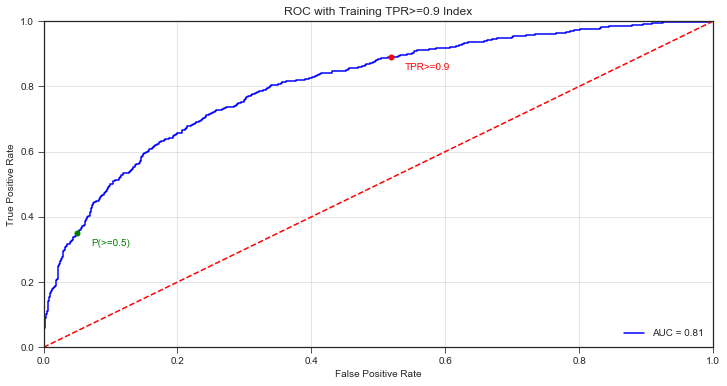


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      2237       118
condition_pos       484       261


the Accuracy is: 0.806
npv: 0.822
the classification_report:
               precision    recall  f1-score   support

           0      0.822     0.950     0.881      2355
           1      0.689     0.350     0.464       745

   micro avg      0.806     0.806     0.806      3100
   macro avg      0.755     0.650     0.673      3100
weighted avg      0.790     0.806     0.781      3100


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.120


               pred_neg  pred_pos
condition_neg      1124      1231
condition_pos        81       664


the Accuracy is: 0.577
npv: 0.933
the classification_report:
               precision    recall  f1-score   support

           0      0.933     0.477     0.631      2355
           1      0.350     0.891     0.503       745

   micro avg      0

In [102]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test,
                              training=False,
                              train_threshold= cv_summary_df.loc['XGBClassifier','tp_threshold'],
                              model_name='xgboost', folder_name=folder)

In [84]:
save_boolean=True

time: 445 µs


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


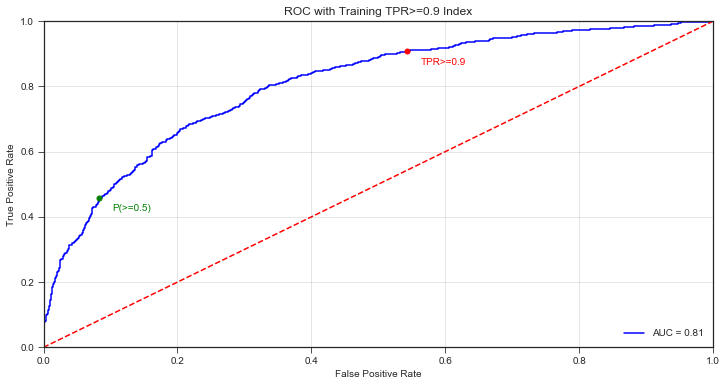


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      2157       198
condition_pos       404       341


the Accuracy is: 0.806
npv: 0.842
the classification_report:
               precision    recall  f1-score   support

           0      0.842     0.916     0.878      2355
           1      0.633     0.458     0.531       745

   micro avg      0.806     0.806     0.806      3100
   macro avg      0.737     0.687     0.704      3100
weighted avg      0.792     0.806     0.794      3100


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.268


               pred_neg  pred_pos
condition_neg      1074      1281
condition_pos        69       676


the Accuracy is: 0.565
npv: 0.940
the classification_report:
               precision    recall  f1-score   support

           0      0.940     0.456     0.614      2355
           1      0.345     0.907     0.500       745

   micro avg      0

In [103]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test,
                         training=False,train_threshold= cv_summary_df.loc['RandomForestClassifier','tp_threshold'],
                         model_name='rf', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


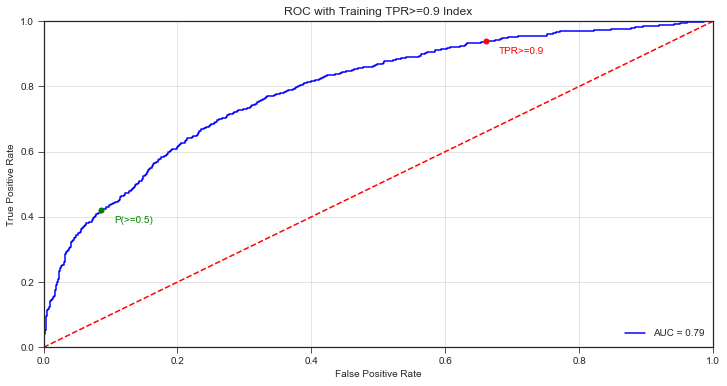


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      2152       203
condition_pos       432       313


the Accuracy is: 0.795
npv: 0.833
the classification_report:
               precision    recall  f1-score   support

           0      0.833     0.914     0.871      2355
           1      0.607     0.420     0.496       745

   micro avg      0.795     0.795     0.795      3100
   macro avg      0.720     0.667     0.684      3100
weighted avg      0.778     0.795     0.781      3100


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.121


               pred_neg  pred_pos
condition_neg       790      1565
condition_pos        45       700


the Accuracy is: 0.481
npv: 0.946
the classification_report:
               precision    recall  f1-score   support

           0      0.946     0.335     0.495      2355
           1      0.309     0.940     0.465       745

   micro avg      0

In [104]:
mlp_eval= classifier_eval(mlp, x=np.array(x_test), y=y_test,
                          training=False,train_threshold= cv_summary_df.loc['MLPClassifier','tp_threshold'],
                          model_name='mlp', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


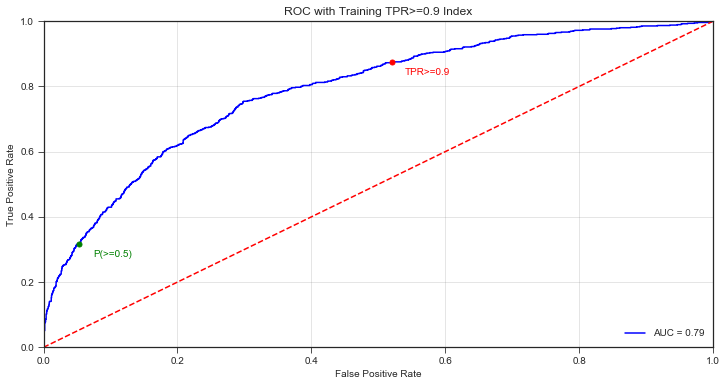


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      1793       562
condition_pos       246       499


the Accuracy is: 0.739
npv: 0.879
the classification_report:
               precision    recall  f1-score   support

           0      0.879     0.761     0.816      2355
           1      0.470     0.670     0.553       745

   micro avg      0.739     0.739     0.739      3100
   macro avg      0.675     0.716     0.684      3100
weighted avg      0.781     0.739     0.753      3100


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.121


               pred_neg  pred_pos
condition_neg      1119      1236
condition_pos        93       652


the Accuracy is: 0.571
npv: 0.923
the classification_report:
               precision    recall  f1-score   support

           0      0.923     0.475     0.627      2355
           1      0.345     0.875     0.495       745

   micro avg      0

In [105]:
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test,
                          training=False,train_threshold= cv_summary_df.loc['SVC','tp_threshold'],
                          model_name='svc', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


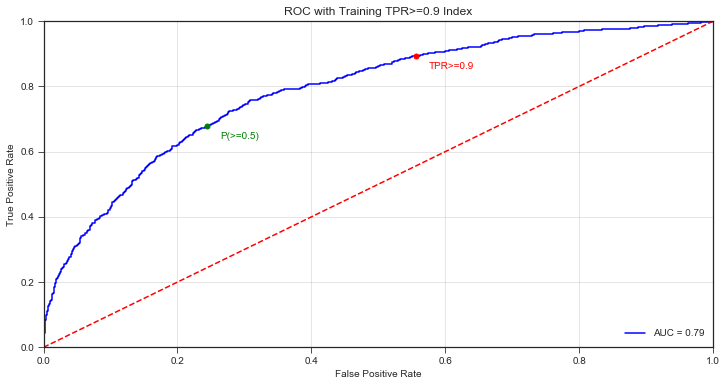


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      1780       575
condition_pos       240       505


the Accuracy is: 0.737
npv: 0.881
the classification_report:
               precision    recall  f1-score   support

           0      0.881     0.756     0.814      2355
           1      0.468     0.678     0.553       745

   micro avg      0.737     0.737     0.737      3100
   macro avg      0.674     0.717     0.684      3100
weighted avg      0.782     0.737     0.751      3100


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.290


               pred_neg  pred_pos
condition_neg      1051      1304
condition_pos        80       665


the Accuracy is: 0.554
npv: 0.929
the classification_report:
               precision    recall  f1-score   support

           0      0.929     0.446     0.603      2355
           1      0.338     0.893     0.490       745

   micro avg      0

In [106]:
logreg_eval= classifier_eval(logreg, x=np.array(x_test),
                             training=False,train_threshold= cv_summary_df.loc['LogisticRegression','tp_threshold'],                             
                             y=y_test, model_name='logreg', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


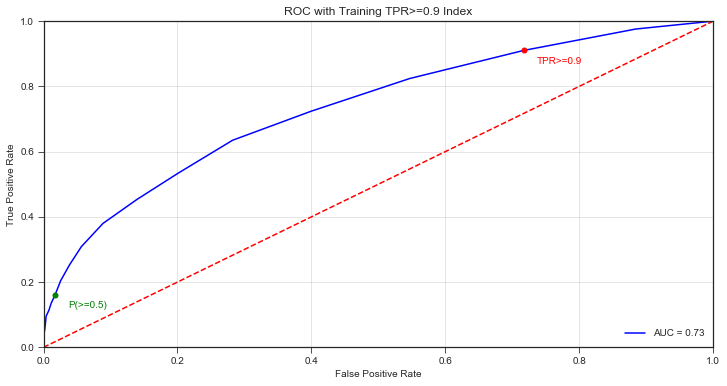


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      2328        27
condition_pos       644       101


the Accuracy is: 0.784
npv: 0.783
the classification_report:
               precision    recall  f1-score   support

           0      0.783     0.989     0.874      2355
           1      0.789     0.136     0.231       745

   micro avg      0.784     0.784     0.784      3100
   macro avg      0.786     0.562     0.553      3100
weighted avg      0.785     0.784     0.720      3100


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.076


               pred_neg  pred_pos
condition_neg       667      1688
condition_pos        67       678


the Accuracy is: 0.434
npv: 0.909
the classification_report:
               precision    recall  f1-score   support

           0      0.909     0.283     0.432      2355
           1      0.287     0.910     0.436       745

   micro avg      0

In [107]:
knn_eval= classifier_eval(knn, x=np.array(x_test), y=y_test,
                          training=False,train_threshold= cv_summary_df.loc['KNeighborsClassifier','tp_threshold'],           
                          model_name='knn', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


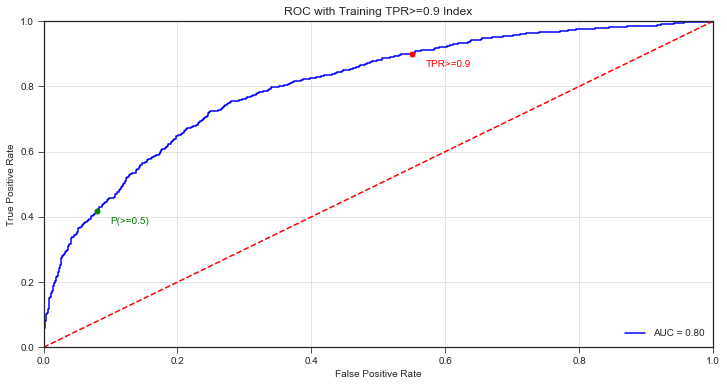


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      2165       190
condition_pos       433       312


the Accuracy is: 0.799
npv: 0.833
the classification_report:
               precision    recall  f1-score   support

           0      0.833     0.919     0.874      2355
           1      0.622     0.419     0.500       745

   micro avg      0.799     0.799     0.799      3100
   macro avg      0.727     0.669     0.687      3100
weighted avg      0.782     0.799     0.784      3100


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.190


               pred_neg  pred_pos
condition_neg      1066      1289
condition_pos        74       671


the Accuracy is: 0.560
npv: 0.935
the classification_report:
               precision    recall  f1-score   support

           0      0.935     0.453     0.610      2355
           1      0.342     0.901     0.496       745

   micro avg      0

In [108]:
ensemble_eval= classifier_eval(ensemble, 
                               x=np.array(x_test),
                               y=y_test, 
                               training=False,
                               train_threshold= cv_summary_df.loc['VotingClassifier','tp_threshold'],                             
                               model_name='ensemble',
                               folder_name=folder, save=True)

looks like its the rashamon effect that doesn't benefit from ensembling.

ie there are hidden variables that can discriminate the patients.

# classification performance table

In [109]:
test_summary_df= pd.DataFrame([xgboost_eval, rf_eval, logreg_eval,  mlp_eval, svc_eval, knn_eval, ensemble_eval])
test_summary_df=test_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)
if save_boolean==True:
    save_df(test_summary_df, df_name='default', rel_path='/tables/')
print(test_summary_df)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/16122019_72_hr_window/
                          auc  precision  recall     f1    npv  threshold
model                                                                    
XGBClassifier           0.806      0.350   0.891  0.503  0.933      0.120
RandomForestClassifier  0.805      0.345   0.907  0.500  0.940      0.268
VotingClassifier        0.802      0.342   0.901  0.496  0.935      0.190
MLPClassifier           0.788      0.309   0.940  0.465  0.946      0.121
LogisticRegression      0.787      0.338   0.893  0.490  0.929      0.290
SVC                     0.787      0.345   0.875  0.495  0.923      0.121
KNeighborsClassifier    0.735      0.287   0.910  0.436  0.909      0.076
time: 22.2 ms


# QC: checking performance on training set for xgboost and rf

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


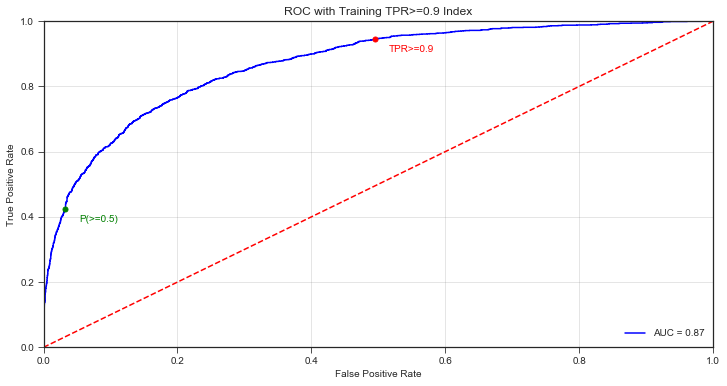


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      5332       180
condition_pos       973       720


the Accuracy is: 0.840
npv: 0.846
the classification_report:
               precision    recall  f1-score   support

           0      0.846     0.967     0.902      5512
           1      0.800     0.425     0.555      1693

   micro avg      0.840     0.840     0.840      7205
   macro avg      0.823     0.696     0.729      7205
weighted avg      0.835     0.840     0.821      7205


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.120


               pred_neg  pred_pos
condition_neg      2784      2728
condition_pos        94      1599


the Accuracy is: 0.608
npv: 0.967
the classification_report:
               precision    recall  f1-score   support

           0      0.967     0.505     0.664      5512
           1      0.370     0.944     0.531      1693

   micro avg      0

In [110]:
xgboost_train= classifier_eval(xgboost, x=np.array(x_train), y=y_train,
                               training=False,
                               train_threshold= cv_summary_df.loc['XGBClassifier','tp_threshold'],  
                               model_name='xgboost_train', folder_name=folder, save=False)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


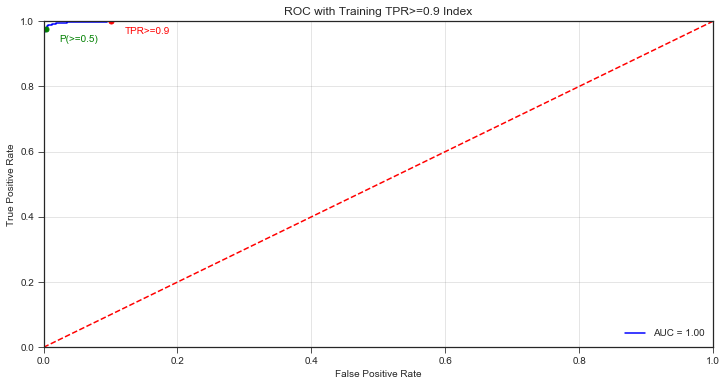


******* Using 0.5 Classification Threshold *******

               pred_neg  pred_pos
condition_neg      5495        17
condition_pos        41      1652


the Accuracy is: 0.992
npv: 0.993
the classification_report:
               precision    recall  f1-score   support

           0      0.993     0.997     0.995      5512
           1      0.990     0.976     0.983      1693

   micro avg      0.992     0.992     0.992      7205
   macro avg      0.991     0.986     0.989      7205
weighted avg      0.992     0.992     0.992      7205


******* Using Optimal TPR>=0.9 Classification Threshold *******


the Youden optimal index is : 0.268


               pred_neg  pred_pos
condition_neg      4052      1460
condition_pos         0      1693


the Accuracy is: 0.797
npv: 1.000
the classification_report:
               precision    recall  f1-score   support

           0      1.000     0.735     0.847      5512
           1      0.537     1.000     0.699      1693

   micro avg      0

In [128]:
rf_train= classifier_eval(rf, x=np.array(x_train), y=y_train,
                          training=False,
                          train_threshold= cv_summary_df.loc['RandomForestClassifier','tp_threshold'],  
                          model_name='rf_train', folder_name=folder, save=False)

# publication figures

In [112]:
# making a model dictionary for ease of use in plotting
keys= ['rf', 'xgboost', 'logreg', 'mlp','svc', 'knn', 'ensemble']
model_list=[rf, xgboost, logreg, mlp, svc, knn, ensemble]
models_dic={}
for i in range(0,len(model_list)):
    models_dic.update({keys[i] : model_list[i]} )

time: 1.55 ms


## stacked roc curve 

In [113]:
def roc_publishing(model, x, y, proba_input=False,pos_label=1, print_default=True, model_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    model_name=type(model).__name__

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds, tp90=True)
    
    return(fpr, tpr, roc_auc, roc_df, idx)

time: 1.69 ms


In [130]:
def stacked_roc(x_test, y_test, models_dic, first_bold=True):
    """
    plotting function to plot a stacked ROC based on models in a dictionary. 
    first_bold=True means that the first model in the dic will stand out and be a solid line, while others are dotted
    """
    
    global save_boolean
    
    plt.style.use('seaborn-white')
    plt.rcParams['figure.figsize'] = [7, 4]
    
    if first_bold==True: i=0
    else: i=1
        
#         #####
#     y_proba = model.predict_proba(x)[:,1]
        
#     fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
#     roc_auc = metrics.auc(fpr, tpr)
    
#     #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
#     youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

#     #plotting roc
#     plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder)    
#         ######
        
    for model_name in models_dic.keys():
        #ax4= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
        if i==0:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            print(model_name, roc_auc)
            ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
#             plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#             plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        
        else:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            print(model_name, roc_auc)
            ax1= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
#             plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#             plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        i+=1
        
    ###annotating the plot
    plt.legend(loc = 'lower right')   
#     plt.annotate(s="P(0.5)",xy=(0.71, 0.50),color='black', size=10) #textcoords #alt: xy=(0.78, 0.345)
#     plt.plot(0.68, 0.51, 'ro', color='black') #alt: (0.73, 0.36, 'ro', color='black')
#     plt.annotate(s="P(tuned)",xy=(0.71, 0.56),color='black', size=10) #textcoords #alt: xy=(0.78, 0.405)
#     plt.plot(0.68, 0.57, 'ro', color='r') #alt: (0.73, 0.42, 'ro', color='r')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', size=14)
    plt.xlabel('False Positive Rate', size=14)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)

    if save_boolean==True:
        saveplot(plt,'stacked_roc')
    else: pass
    plt.show()

time: 6.82 ms


In [115]:
models_dic.keys()

dict_keys(['rf', 'xgboost', 'logreg', 'mlp', 'svc', 'knn', 'ensemble'])

time: 4.8 ms


rf 0.8053759671696662
xgboost 0.8060188945411021
logreg 0.7869334131292836
mlp 0.7883811396571622
svc 0.7869989598027901
knn 0.7348409068239786
ensemble 0.8023009732256088
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


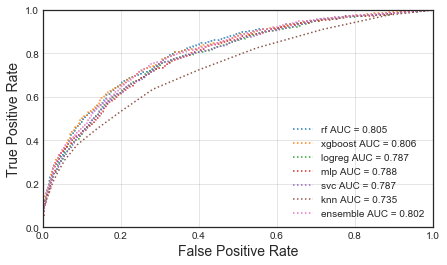

time: 3.61 s


In [131]:
stacked_roc(x_test, y_test, models_dic, first_bold=False)

# 

# variable importance
* first: find the top N (default=10) most important variables for each model
* second: make a set of all unique variables present in the combined list of all models top N variables = varimp_set
* find the variable importances for each model for varimp_set variables
* scale the variable importance for each model relative to the MOST IMPORTANT VARIABLE:
 * ie: var1= 50 (max); var2= 25; var3= 5 --> varimp: var1=100, var2=50, var3=10
* plot these as a line plot in descending order for the best performing model

In [117]:
from parameters import n_varimp

time: 751 µs


In [118]:
def find_N_varimp_set(x_train, models_dic):
    """
    function that takes in a dictionary of models and the x_train dataframe and returns the set of variables present in the combined list of each model's top N most important variables.
    1) find top N variables for each model
    2) make list of all models top N
    3) filter to only unique values in list = varimp_names
    """
    global n_varimp
    features_dic={}
    top_set_dic={}

    for model_name in models_dic.keys():
        model= models_dic[model_name]
        print(model_name)
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        elif model_name in ['logreg','svc']:
            feature_importance = abs(model.coef_[0])
            sorted_idx = np.argsort(feature_importance)[-n_varimp:]#[0]
            features =list(np.array(x_train.columns)[sorted_idx][-n_varimp:])
            features_dic.update( {model_name :features } )
        else:
            feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
            features=feat_importances.nlargest(n_varimp).sort_values()
            features=list(features.reset_index()['index'])
            features_dic.update( {model_name :features } )
    #######
    set_features=[]

    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)

    return(varimp_names)

time: 3.04 ms


In [119]:
def topN_rel_imp(models_dic, varimp_names):
    """
    input:dictionary of models and the top N set of important variables among models
    output: relative variable importance for each model of all set(varimp_names) variables.
    note: relative variable importance determined by dividing each variable importance by the value of the most important variable. this makes all values a comparison to the most important varaible:
    ie 50 rel variable importance = half as important as the most important variable
    """
    
    # finding the index of the set(varimp_names) in the dataframe.  
    #getting index of the set(top10) variables in x_train
    xtrain_column_index_list=[]
    for element in varimp_names:
        variable_index=list(x_train).index(element)
        xtrain_column_index_list.append(variable_index)
    
    top_set_dic={} #instantiating dictionary
    for model_name in models_dic.keys(): ##now that we have set of top N variables for each model. we can make relative importance for all unique variables in the set
        model= models_dic[model_name]
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        
        elif model_name in ['logreg','svc']: 
            imp= abs(model.coef_[0])[xtrain_column_index_list]
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_varimp:])
            top_set= pd.Series(rel_imp,features).sort_values()
            top_set_dic.update( {model_name :top_set } )

        else:
            imp=pd.Series(models_dic[model_name].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
            imp=imp.sort_values()
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])
            top_set= rel_imp
            top_set_dic.update( {model_name :top_set } )

    return(top_set_dic)

time: 2.58 ms


In [120]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio':'PaO2:FiO2',
#             'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
#             'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
#             'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 1.25 ms


In [121]:
def plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=80):
    """
    plot the variable importance plots as a lineplot
    rotation: the amount of xvar rotation
    """
    global save_boolean
    
    df_base=pd.DataFrame(index=varimp_names)  

    for model_name in top_set_dic.keys():
        df_base[model_name]= top_set_dic[model_name]

    adjusted_names=roc_name_adjust(varimp_names)
    df_base.index=adjusted_names
    df_base.sort_values('rf', ascending=False)

    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [12,6]#[7, 7]
    plt.plot(df_base.sort_values('rf', ascending=True))
    #plt.set_xticklabels(adjusted_names,rotation=30)
    plt.xticks(rotation=xvar_rotation, size=14)#, weight='bold')#, ha='right')
    plt.ylabel("Relative Variable Importance", size=18)#, weight='bold')
    plt.legend(list(df_base), prop={'size': 14})
    
    if save_boolean==True:
        saveplot(plt,'variable_importance')

    return(df_base)



time: 2.02 ms


rf
xgboost
logreg
mlp
svc
knn
ensemble
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_72_hr_window


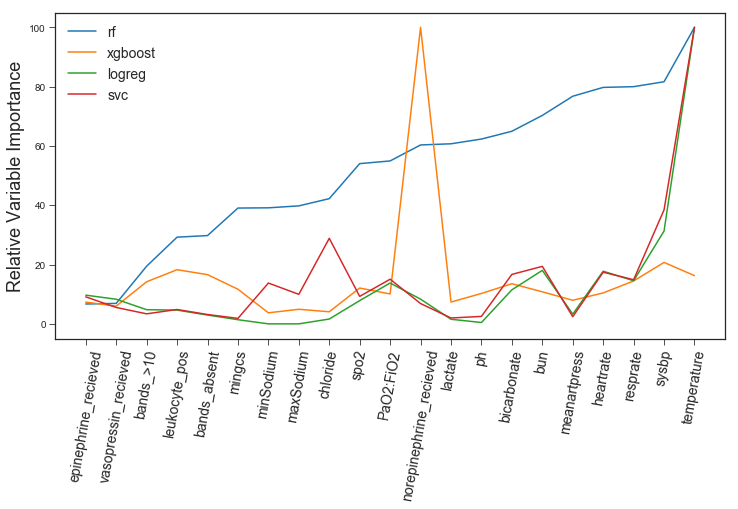

time: 764 ms


In [122]:
#find set(topN) variables
varimp_names= find_N_varimp_set(x_train, models_dic)

#find rel importance of set(topN) variables for each model
top_set_dic= topN_rel_imp(models_dic, varimp_names)

#plot the variable importance plot
topN_rel_imp_df= plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=80)

In [123]:
all_features=[
    'bilirubin','bun','chloride',
     'creatinine','glucose','heartrate',
     'inr','lactate','potassium',
     'ptt','resprate','sum_elix',
     'temperature','bicarbonate','diasbp',
     'hemoglobin','meanartpress','mingcs',
     'pao2fio2ratio','ph','platelet',
     'spo2','sysbp','maxCalcium',
     'maxSodium','maxWBC','minCalcium',
     'minSodium','minWBC','weight',
     'yearsold','ethnicity_black','ethnicity_hispanic',
     'ethnicity_unknown/other','ethnicity_white/nonhispanic','bands_>10',
     'bands_absent','pco2_>50','pco2_absent',
     'any_vasoactives_recieved','leukocyte_pos','nitrite_pos',
     'vent_recieved_None','vent_recieved_Oxygen','dobutamine_recieved',
     'gender_M','gender_NA','dopamine_recieved',
     'epinephrine_recieved','norepinephrine_recieved','phenylephrine_recieved',
     'rrt_recieved','vasopressin_recieved','cancer_elix_no_cancer_cormorb'
]

time: 1.97 ms


# Model Saving

In [124]:
def model_save(model, model_name):
    import pickle
    modelpath=str(repository_path)+'/models/{}_{}'.format(date,folder)

    if not os.path.exists(modelpath):
        print(modelpath)
        os.makedirs(modelpath)

    filename = str(modelpath)+'/finalized_{}.sav'.format(model_name)
    pickle.dump(model, open(filename, 'wb'))

time: 16 ms


In [125]:
model_save(xgboost,'xgboost')
model_save(rf,'rf')
model_save(logreg,'logreg')
model_save(svc,'svc')
model_save(knn,'knn')
model_save(mlp,'mlp')
model_save(ensemble,'ensemble')

time: 258 ms


In [126]:
folder

'72_hr_window'

time: 2.77 ms


In [127]:
date

'16122019'

time: 4.2 ms


cool model debugging code, useful to make validation curves across hyperparameters:

In [65]:
# def val_curve_plot(train_scoreNum, test_scoreNum, param_range, param_name, rename_x_tick=False, param_range_name=['0','1']):
#     """quick function to plot a validation curve across different hyperparameters"""
#     plt.rcParams['figure.figsize'] = [7, 4]
    
#     train_scores_mean = np.mean(train_scoreNum, axis=1)
#     train_scores_std = np.std(train_scoreNum, axis=1)
#     test_scores_mean = np.mean(test_scoreNum, axis=1)
#     test_scores_std = np.std(test_scoreNum, axis=1)

#     plt.title("Validation Curve with RF and parameter:{}".format(param_name))
#     plt.xlabel(r"$\gamma$")
#     plt.ylabel("Score")
#     plt.ylim(0.6, 1.1)
#     try:
#         plt.xlim(0, max(param_range))
#     except TypeError:
#         pass
#     lw = 2

#     if rename_x_tick==False:
#         param_range_name=param_range
#     plt.errorbar(param_range_name,train_scores_mean, yerr=train_scores_std, alpha=0.6, color='darkorange', lw=lw, label='train')
#     plt.errorbar(param_range_name,test_scores_mean, yerr=test_scores_std, alpha=0.6, color='blue', lw=lw, label='test')
#     plt.legend(loc='best')
#     plt.show()

time: 869 µs


In [66]:
# from sklearn.model_selection import validation_curve

# param_range=[2, 10, 15, 25, 35, 50, 200]#[100, 300, 500, 750, 800, 1200]

# train_scoreNum, test_scoreNum = validation_curve(
#                                 RandomForestClassifier(),
#                                 X = x, y = y, 
#                                 param_name = 'n_estimators', 
#                                 param_range = param_range, cv = 5)

# val_curve_plot(train_scoreNum, test_scoreNum, param_range, param_name='n_estimators')

time: 503 µs


In [67]:
#list(x_train2.loc[:,[x for x in list(x_train2) if x not in categorical]])

time: 412 µs


# exploring LIME visualization package (depreciated at current point)

In [68]:
# x_train2=x_train.copy()

time: 14.8 ms


In [69]:
# # trying to get LIME package working
# import lime
# import lime.lime_tabular

time: 587 µs


In [70]:
# explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train), feature_names=list(x_train), class_names=[0,1], discretize_continuous=True)

# explainer = lime.lime_tabular.LimeTabularExplainer(train ,feature_names = feature_names,class_names=class_names,
#                                                    categorical_features=categorical_features, 
#                                                    categorical_names=categorical_names, kernel_width=3

time: 4.49 ms


In [71]:
# i = np.random.randint(0, x_test.shape[0])
# exp = explainer.explain_instance(np.array(x_test)[i], rf.predict_proba, num_features=len(list(x_train)), top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

time: 389 µs


In [72]:
# y_test[i]

time: 622 µs


In [73]:
# np.array(x_test)[i]

time: 297 µs


In [74]:
# x_test.iloc[i,:5]

time: 332 µs


In [75]:
# exp = explainer.explain_instance(np.array(x_test)[i], xgboost.predict_proba, num_features=len(list(x_train)), top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

time: 437 µs


Now, there is a lot going on here. First, note that the row we are explained is displayed on the right side, in table format. Since we had the show_all parameter set to false, only the features used in the explanation are displayed.

The value column displays the original value for each feature.

Note that LIME has discretized the features in the explanation. This is because we let discretize_continuous=True in the constructor (this is the default). Discretized features make for more intuitive explanations.

In [76]:
folder

'72_hr_window'

time: 1.91 ms
